In [1]:
!ls -lrt /home/quahb/caipi_denoising/data/results
!ls -lrt /home/quahb/caipi_denoising/data/datasets

total 112
-rw-rw-r--  1 quahb quahb  5109 Aug 25 01:09 in
-rw-rw-r--  1 quahb quahb  5028 Aug 25 01:43 out
drwxrwxr-x 10 quahb quahb  4096 Sep  1 13:58 old
drwxrwxr-x  2 quahb quahb 28672 Sep  4 20:55 ps256_th_varynoise_m3_reg_test_v1
drwxrwxr-x  2 quahb quahb 20480 Sep 27 15:24 ps256_es32_th_varynoise_m3_reg_test
drwxrwxr-x  2 quahb quahb  4096 Sep 28 18:57 ps128_es64_th_varynoise_m3_reg_test
drwxrwxr-x  2 quahb quahb 20480 Sep 29 17:13 ps256_th_varynoise_m3_reg_test
drwxrwxr-x  2 quahb quahb 20480 Oct 11 16:22 ps256_th_varynoise_test
total 2160
drwxrwxr-x 2 quahb quahb  20480 Sep  1 13:41 testing_set_pp
drwxrwxr-x 2 quahb quahb  12288 Sep  1 13:42 training_set_pp
drwxrwxr-x 2 quahb quahb  20480 Sep  1 13:45 reg_testing_set_pp
drwxrwxr-x 2 quahb quahb 528384 Sep  1 14:00 ps256_th_singlenoise
drwxrwxr-x 2 quahb quahb 540672 Sep  7 17:35 ps256_th_varynoise
drwxrwxr-x 2 quahb quahb 544768 Sep 22 15:48 ps256_es32_th_varynoise
drwxrwxr-x 2 quahb quahb 540672 Sep 22 15:50 ps128_es64_th_vary

In [48]:
denoised_name = 'ps256_th_varynoise_test'

import json
import numpy as np
import nibabel as nib
import matplotlib as mpl
from datetime import date
mpl.rc('image', cmap='gray')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import sys
import nibabel as nib
import os

sys.path.insert(1, '/home/quahb/caipi_denoising/src')

%load_ext autoreload
%autoreload 2

from preparation.gen_data import get_masks
from utils.data_io import load_dataset

from evaluation.compute_metrics import compute_metrics, ssim, luminance, contrast, structure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

In [2]:
mask_data = get_masks()
train_data = load_dataset('/home/quahb/caipi_denoising/data/datasets/training_set_pp')
test_data = load_dataset('/home/quahb/caipi_denoising/data/datasets/testing_set_pp')
#reg_test_data = load_dataset('/home/quahb/caipi_denoising/data/datasets/reg_testing_set_pp')
denoised = load_dataset(f'/home/quahb/caipi_denoising/data/results/{denoised_name}')


subj_ids = list(mask_data.keys())
dataset = {}

for i, subj_id in enumerate(subj_ids):
    dataset[subj_id] = {}
    dataset[subj_id]['data'] = {}
    
    for key, val in train_data.items():
        if subj_id in key:
            dataset[subj_id]['data']['epi'] = val[0]
            break

    for key, val in test_data.items():
        if subj_id in key and '1x2' in key:
            dataset[subj_id]['data']['cpi1x2'] = val[0]
        elif subj_id in key and '1x3' in key:
            dataset[subj_id]['data']['cpi1x3'] = val[0]
        elif subj_id in key and '2x2' in key:
            dataset[subj_id]['data']['cpi2x2'] = val[0]

    dataset[subj_id]['data']['lesion_mask'] = mask_data[subj_id]['probability_map']
    dataset[subj_id]['data']['vein_mask'] = mask_data[subj_id]['vein_mask']
    dataset[subj_id]['data']['wm_mask'] = mask_data[subj_id]['3D_T1_Reg_pve_2']
    
    for key, val in denoised.items(): # val is tuple of (input image, denoised image)
        if subj_id in key and '1x2' in key:
            dataset[subj_id]['data']['run1x2'] = val
        elif subj_id in key and '1x3' in key:
            dataset[subj_id]['data']['run1x3'] = val
        elif subj_id in key and '2x2' in key:
            dataset[subj_id]['data']['run2x2'] = val

print(dataset['1_01_016-V1']['data'].keys())
print(dataset['1_01_016-V1']['data']['epi'].shape)

probability_map: 100%|██████████████████████████| 52/52 [00:18<00:00,  2.81it/s]


dict_keys(['epi', 'cpi1x2', 'cpi1x3', 'cpi2x2', 'lesion_mask', 'vein_mask', 'wm_mask', 'run1x2', 'run1x3', 'run2x2'])
(384, 312, 256)


# Compute & Load metrics into dataset

In [3]:
'''
dataset: {
    subj_id: {
        data: {
            EPI: arr
            cpi1x2: arr
            cpi1x3: arr
            cpi2x2: arr
            wm_mask: arr
            vein_mask: arr
            lesion_mask: arr
            run1x2: (x,y)
            run1x3: (x,y)
            run2x2: (x,y)
        }
        metrics: {
            1x2: {
                psnr: (native, denoised)
                ssim: ()
                cnr_vw: ()
                cnr_lv: ()
                ...
            }
            1x3: {}
            2x2: {}
        }
    }
}
'''

N=len(subj_ids)

for i, subj_id in enumerate(list(dataset.keys())[:N]):
    print(i, subj_id, end=' ')
    dataset[subj_id]['metrics'] = {}
    dataset[subj_id]['metrics']['1x2'] = {}
    dataset[subj_id]['metrics']['1x3'] = {}
    dataset[subj_id]['metrics']['2x2'] = {}

    epi = dataset[subj_id]['data']['epi']
    wm_mask = dataset[subj_id]['data']['wm_mask']
    vein_mask = dataset[subj_id]['data']['vein_mask']
    lesion_mask = dataset[subj_id]['data']['lesion_mask']

    # brain_mask = dataset[subj_id]['data']['brain_mask']
    #brain_mask = np.moveaxis(nib.load('/home/quahb/Mask_Reg.nii.gz').get_fdata(), 1, 0)
    #brain_mask = np.array(np.moveaxis(nib.load('/home/quahb/Mask_Reg.nii.gz').get_fdata(), 1, 0) > 0.5, dtype=np.uint8)

    cpi1x2, run1x2 = dataset[subj_id]['data']['cpi1x2'], dataset[subj_id]['data']['run1x2'][1]
    cpi1x3, run1x3 = dataset[subj_id]['data']['cpi1x3'], dataset[subj_id]['data']['run1x3'][1]
    cpi2x2, run2x2 = dataset[subj_id]['data']['cpi2x2'], dataset[subj_id]['data']['run2x2'][1]

    dataset[subj_id]['metrics']['1x2'] = compute_metrics(epi, cpi1x2, run1x2, vein_mask, wm_mask, lesion_mask, subj_id=subj_id)
    dataset[subj_id]['metrics']['1x3'] = compute_metrics(epi, cpi1x3, run1x3, vein_mask, wm_mask, lesion_mask, subj_id=subj_id)
    dataset[subj_id]['metrics']['2x2'] = compute_metrics(epi, cpi2x2, run2x2, vein_mask, wm_mask, lesion_mask, subj_id=subj_id)

0 1_01_016-V1 

/home/quahb/.conda/envs/caipi_denoising/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/quahb/.conda/envs/caipi_denoising/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/quahb/.conda/envs/caipi_denoising/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/quahb/.conda/envs/caipi_denoising/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/quahb/.conda/envs/caipi_denoising/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 1_01_018-V1 

/home/quahb/caipi_denoising/src/evaluation/compute_metrics.py:83: RuntimeWarning: divide by zero encountered in double_scalars
  return mu / sd


2 1_01_021-V1 3 1_01_022-V1 4 1_01_024-V1 5 1_01_026-V1 6 1_01_028-V1 7 1_01_029-V1 8 1_01_031-V1 9 1_01_032-V1 10 1_01_036-V1 11 1_01_037-V1 12 1_01_037-V1-2 13 1_01_038-V1 14 1_01_039-V1 15 1_01_040-V1 16 1_01_041-V1 17 1_07_003-V1 18 1_07_004-V1 19 1_07_005-V1 20 1_07_006-V1 21 1_07_009-V1 22 1_07_010-V1 23 1_07_011-V1 24 1_07_013-V1 25 1_07_017-V1 26 1_07_021-V1 27 1_07_022-V1 28 1_07_023-V1 29 1_07_025-V1 30 1_07_028-V1 31 1_07_029-V1 32 1_07_030-V1 33 1_07_031-V1 34 1_07_032-V1 35 1_07_034-V1 36 1_07_037-V1 37 1_07_038-V1 38 1_07_039-V1 39 1_07_045-V1 40 1_07_047-V1 41 1_07_051-V1 42 1_07_056-V1 43 1_08_032-V1 44 1_08_035-V1 45 1_08_042-V1 46 1_08_044-V1 47 1_08_045-V1 48 1_08_046-V1 49 1_08_047-V1 50 1_08_049-V1 51 1_08_050-V1 

# Optional: Save Metrics to File

In [ ]:
save_dict = {}

for subj_id in dataset.keys():
    save_dict[subj_id] = {}
    save_dict[subj_id] = dataset[subj_id]['metrics']

s_date = str(date.today())
with open(f'/home/quahb/caipi_denoising/metrics/{denoised_name}_{s_date}.json', 'w') as outfile:
    json.dump(save_dict, outfile)

# Optional: Load Metrics

In [ ]:
if False:
    filename = '/home/quahb/caipi_denoising/metrics/ps256_th_varynoise_m3_reg_test_2022-09-16.json'
    metrics_json = json.load(open(filename))

    for subj_id in metrics_json.keys():
        dataset[subj_id]['metrics'] = metrics_json[subj_id]

# Display Metrics for Single Acceleration by Subject

In [127]:
dataset['1_07_006-V1']['metrics']['2x2'][0].keys()

dict_keys(['axial_psnr'])

In [16]:
ACC='1x3'

metrics_to_display = [
    #'snr'
    #'mse', 'psnr', 'snr',
    'ssim', 'luminance', 'contrast', 'structure', 
    #'cnr_vw', 'cnr_lv', 'cnr_lw'
]

mse_before, mse_after = [], []
psnr_before, psnr_after = [], []
snr_before, snr_after = [], []
ssim_before, ssim_after = [], []
luminance_before, luminance_after = [], []
contrast_before, contrast_after = [], []
structure_before, structure_after = [], []
cnr_vw_before, cnr_vw_after = [], []
cnr_lv_before, cnr_lv_after = [], []
cnr_lw_before, cnr_lw_after = [], []

for subj_id in dataset.keys():
    if 'mse' in metrics_to_display:
        mse_before.append(dataset[subj_id]['metrics'][ACC][0]['mse'])
        mse_after.append(dataset[subj_id]['metrics'][ACC][1]['mse'])
    
    if 'psnr' in metrics_to_display:
        psnr_before.append(dataset[subj_id]['metrics'][ACC][0]['psnr'])
        psnr_after.append(dataset[subj_id]['metrics'][ACC][1]['psnr'])
  
    if 'snr' in metrics_to_display:
        snr_before.append(dataset[subj_id]['metrics'][ACC][0]['snr'])
        snr_after.append(dataset[subj_id]['metrics'][ACC][1]['snr'])

    if 'ssim' in metrics_to_display:
        ssim_before.append(dataset[subj_id]['metrics'][ACC][0]['ssim'])
        ssim_after.append(dataset[subj_id]['metrics'][ACC][1]['ssim'])

    if 'luminance' in metrics_to_display:
        luminance_before.append(dataset[subj_id]['metrics'][ACC][0]['luminance'])
        luminance_after.append(dataset[subj_id]['metrics'][ACC][1]['luminance'])

    if 'contrast' in metrics_to_display:
        contrast_before.append(dataset[subj_id]['metrics'][ACC][0]['contrast'])
        contrast_after.append(dataset[subj_id]['metrics'][ACC][1]['contrast'])

    if 'structure' in metrics_to_display:
        structure_before.append(dataset[subj_id]['metrics'][ACC][0]['structure'])
        structure_after.append(dataset[subj_id]['metrics'][ACC][1]['structure'])

    if 'cnr_vw' in metrics_to_display:
        cnr_vw_before.append(dataset[subj_id]['metrics'][ACC][0]['cnr_vw'])
        cnr_vw_after.append(dataset[subj_id]['metrics'][ACC][1]['cnr_vw'])

    if 'cnr_lv' in metrics_to_display:
        cnr_lv_before.append(dataset[subj_id]['metrics'][ACC][0]['cnr_lv'])
        cnr_lv_after.append(dataset[subj_id]['metrics'][ACC][1]['cnr_lv'])

    if 'cnr_lw' in metrics_to_display:
        cnr_lw_before.append(dataset[subj_id]['metrics'][ACC][0]['cnr_lw'])
        cnr_lw_after.append(dataset[subj_id]['metrics'][ACC][1]['cnr_lw'])

if True:
    for i in range(len(subj_ids)):
        print(
              #subj_ids[i], ', ',
              #mse_before[i],       ', ', mse_after[i],       ', ',
              #psnr_before[i],      ', ', psnr_after[i],      ', ',
              #snr_before[i],       ', ', snr_after[i],       ', ',
              ssim_before[i],      ' ', ssim_after[i],      ' ',
              luminance_before[i], ' ', luminance_after[i], ' ',
              contrast_before[i],  ' ', contrast_after[i],  ' ',
              structure_before[i], ' ', structure_after[i], ' ',
              #cnr_vw_before[i],    ', ', cnr_vw_after[i],    ', ',
              #cnr_lv_before[i],    ', ', cnr_lv_after[i],    ', ',
              #cnr_lw_before[i],    ', ', cnr_lw_after[i]
        )

N/A   0.9880330614698807   N/A   0.9999813600725992   N/A   0.9998694955129332   N/A   0.9976129427343592  
N/A   0.98528900886274   N/A   0.9995087650213251   N/A   0.9998646658236312   N/A   0.9970311235241507  
N/A   0.9794564397891797   N/A   0.9996023075095172   N/A   0.9999969280509323   N/A   0.9965809799713821  
N/A   0.9906126538617965   N/A   0.9999930902259809   N/A   0.9999401130016382   N/A   0.9980258054367735  
N/A   0.9834814678381726   N/A   0.9993609018855613   N/A   0.9999474523490653   N/A   0.9950782878582969  
N/A   0.9894120907889754   N/A   0.9999875298401455   N/A   0.9998910609187586   N/A   0.9964757722671813  
N/A   0.9845935203466086   N/A   0.9995037758904852   N/A   0.9999448701217218   N/A   0.9963915468081866  
N/A   0.9821670298405781   N/A   0.9999939882910157   N/A   0.9999737610951419   N/A   0.9951257497242804  
N/A   0.9909664103530594   N/A   0.9999999979472631   N/A   0.9999587534764909   N/A   0.9984534903853607  
N/A   0.9855175117881565   N/A

In [22]:
dataset['1_08_049-V1']['metrics']['1x2'][1]

{'axial_psnr': (9.160011481354031,
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,

# Vis 1: Plot CAIPI Before/After Denoising with metrics

In [82]:
plt.rcParams.update({'font.size': 13})

def get_metrics_unpack(metrics, acc, BEFORE_AFTER_DENOISE):
    unpack_metrics = [
        metrics[acc][BEFORE_AFTER_DENOISE]['axial_psnr'], metrics[acc][BEFORE_AFTER_DENOISE]['ssim'],
        #metrics[acc][BEFORE_AFTER_DENOISE]['mse'], metrics[acc][BEFORE_AFTER_DENOISE]['psnr'], metrics[acc][BEFORE_AFTER_DENOISE]['snr'], metrics[acc][BEFORE_AFTER_DENOISE]['ssim'],
        #metrics[acc][BEFORE_AFTER_DENOISE]['luminance'], metrics[acc][BEFORE_AFTER_DENOISE]['contrast'], metrics[acc][BEFORE_AFTER_DENOISE]['structure'],
        #metrics[acc][BEFORE_AFTER_DENOISE]['cnr_vw'], metrics[acc][BEFORE_AFTER_DENOISE]['cnr_lv'], metrics[acc][BEFORE_AFTER_DENOISE]['cnr_lwm'],
    ]
    
    return unpack_metrics

def make_plot(subj_id, view, slice_idx):
    n_rows, n_cols = 2, 4
    figure, axis = plt.subplots(n_rows, n_cols, figsize=(28, n_rows * 9), constrained_layout=True)#gridspec_kw = {'wspace': 0, 'hspace':-0.1})
    [axi.set_axis_off() for axi in axis.ravel()]

    data, metrics = dataset[subj_id]['data'], dataset[subj_id]['metrics']

    if view == 'axial':
        view = tuple([slice(slice_idx, slice_idx + 1), slice(312), slice(256)])
    elif view == 'coronal':
        view = tuple([slice(384), slice(slice_idx, slice_idx + 1), slice(256)])
    elif view == 'sagittal':
        view = tuple([slice(384), slice(312), slice(slice_idx, slice_idx + 1)])

    stats_text = 'min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}'
    primary_metrics_text = 'PSNR: {:.3f}, SSIM: {:.3f}'
    ssim_metrics_text = 'Luminance: {:.3f}, Contrast: {:.3f}, Structure: {:.3f}'
    cnr_metrics_text =  'CNR (Vein-WM, Vein-Les, Les-WM): {:.4f}, {:.4f}, {:.4f}'

    epi_bottom_text = stats_text
    caipi_bottom_text = primary_metrics_text #+ '\n' + cnr_metrics_text + '\n' + stats_text

    im, slc_im = data['epi'].astype(np.float64), np.squeeze(data['epi'][view])
    axis[0, 0].imshow(slc_im)
    axis[0, 0].set_title(f'{subj_id}, Slice: {slice_idx}')

    for i, acc in zip(range(1,4), ['1x2', '1x3', '2x2']):
        unpack_metrics = get_metrics_unpack(metrics, acc, 0)
        im, slc_im = data[f'cpi{acc}'].astype(np.float64), np.squeeze(data[f'cpi{acc}'][view])
        axis[0, i].imshow(slc_im)
        axis[0, i].set_title(f'CAIPI{acc}')

    im, slc_im = data['epi'].astype(np.float64), np.squeeze(data['epi'][view])
    axis[1, 0].imshow(slc_im)
    #axis[1, 0].set_title(f'{subj_id}')
    axis[1, 0].set(xlabel=epi_bottom_text.format(np.min(im), np.max(im), np.mean(im), np.std(im)))
    
    for i, acc in zip(range(1,4), ['1x2', '1x3', '2x2']):
        unpack_metrics = get_metrics_unpack(metrics, acc, 1)
        im, slc_im = data[f'run{acc}'][1].astype(np.float64), np.squeeze(data[f'run{acc}'][1][view])
        axis[1, i].imshow(slc_im)
        #axis[1, i].set_title(f'Denoised')

    plt.show()

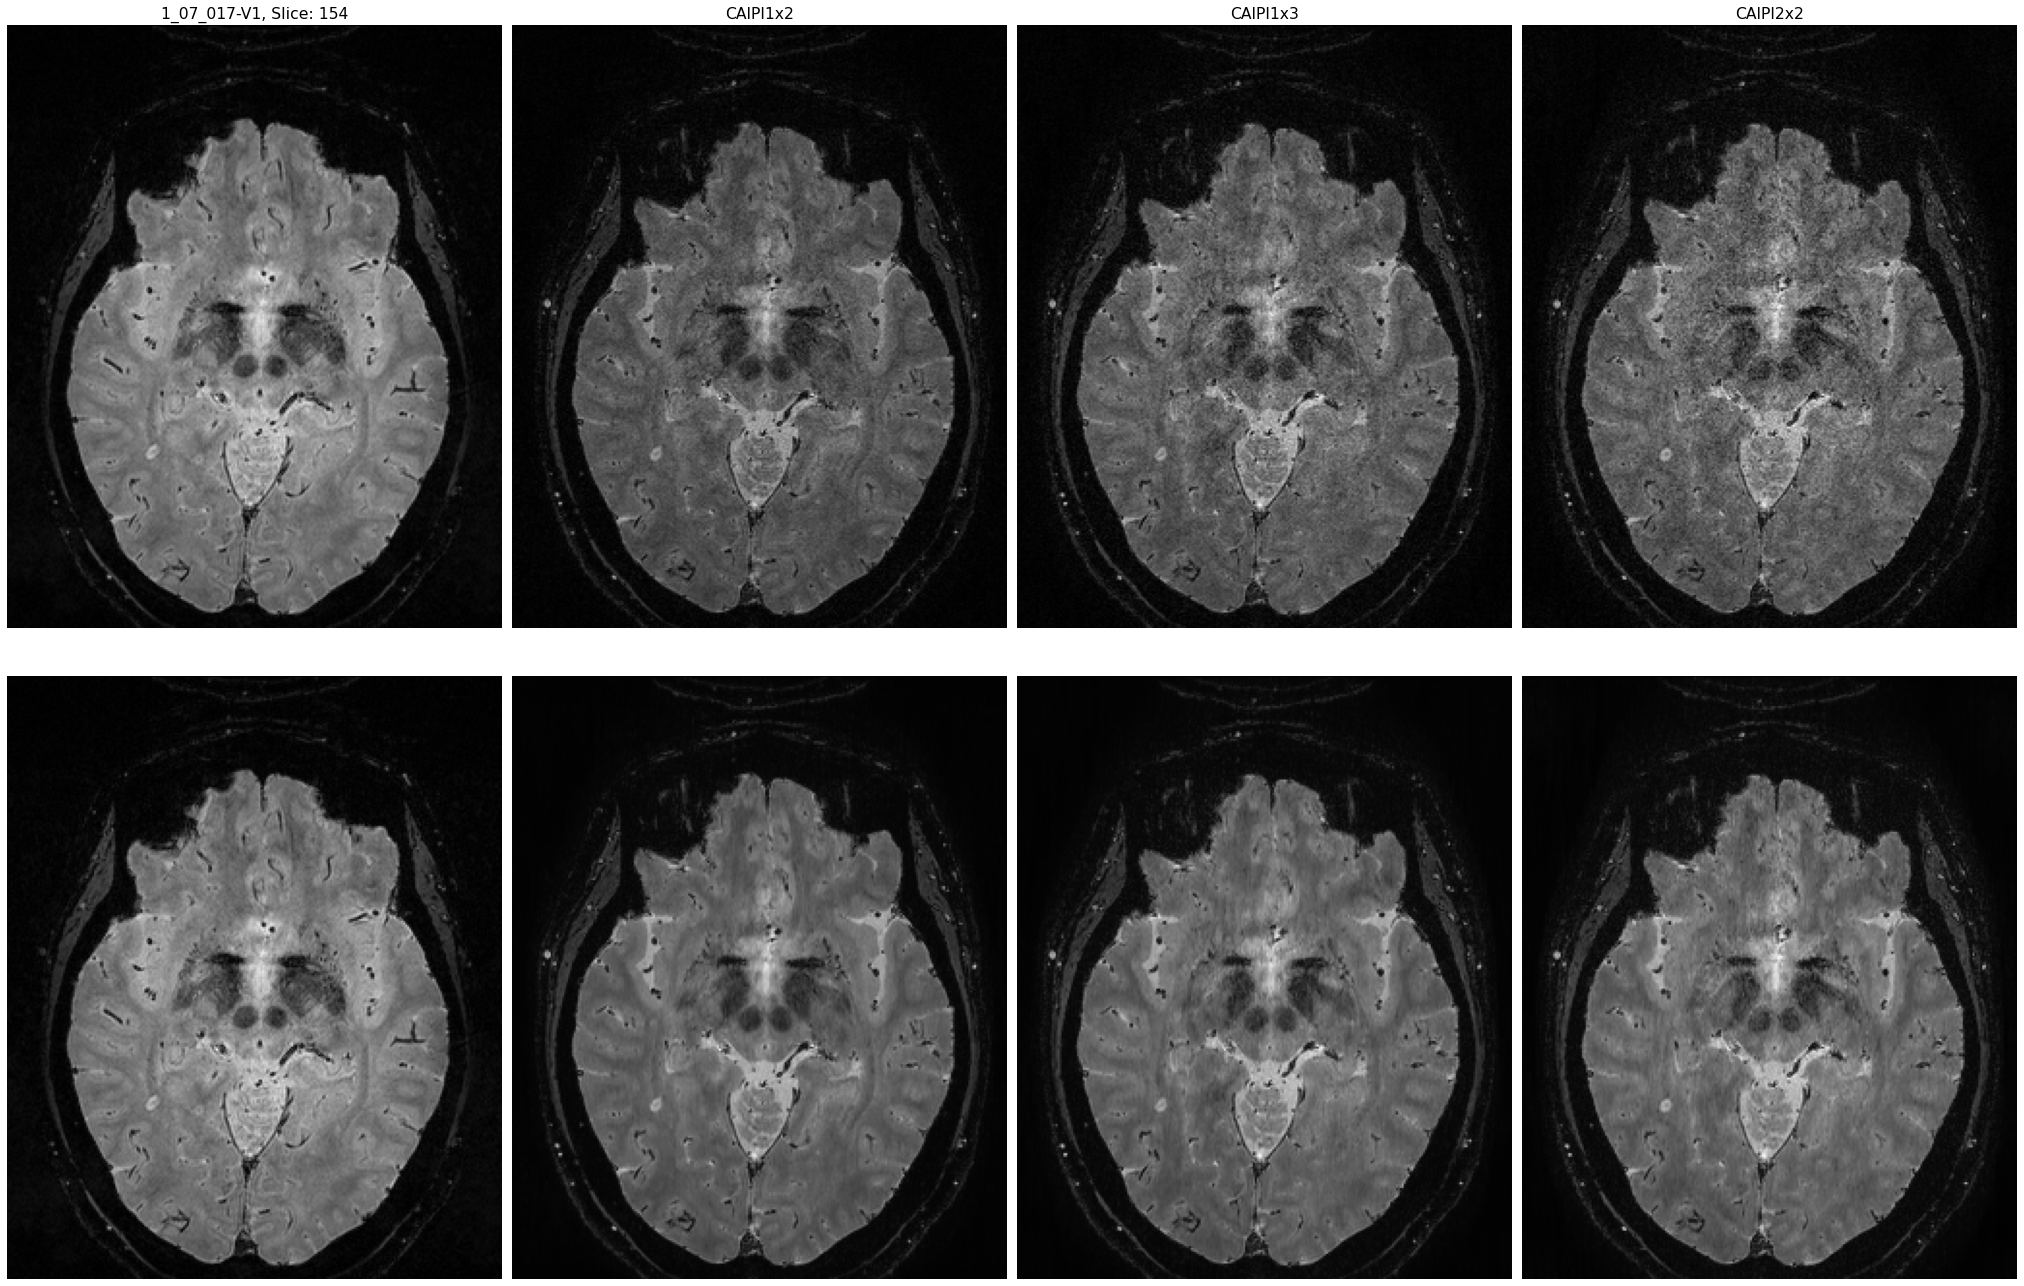

In [100]:
make_plot('1_07_017-V1', 'axial', 154)

# Vis 2: Plot Axial Slice SNR

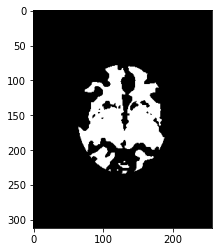

In [28]:
plt.imshow(dataset['1_07_017-V1']['metrics']['2x2'][0]['axial_psnr'][2][154,:,:], cmap='gray')

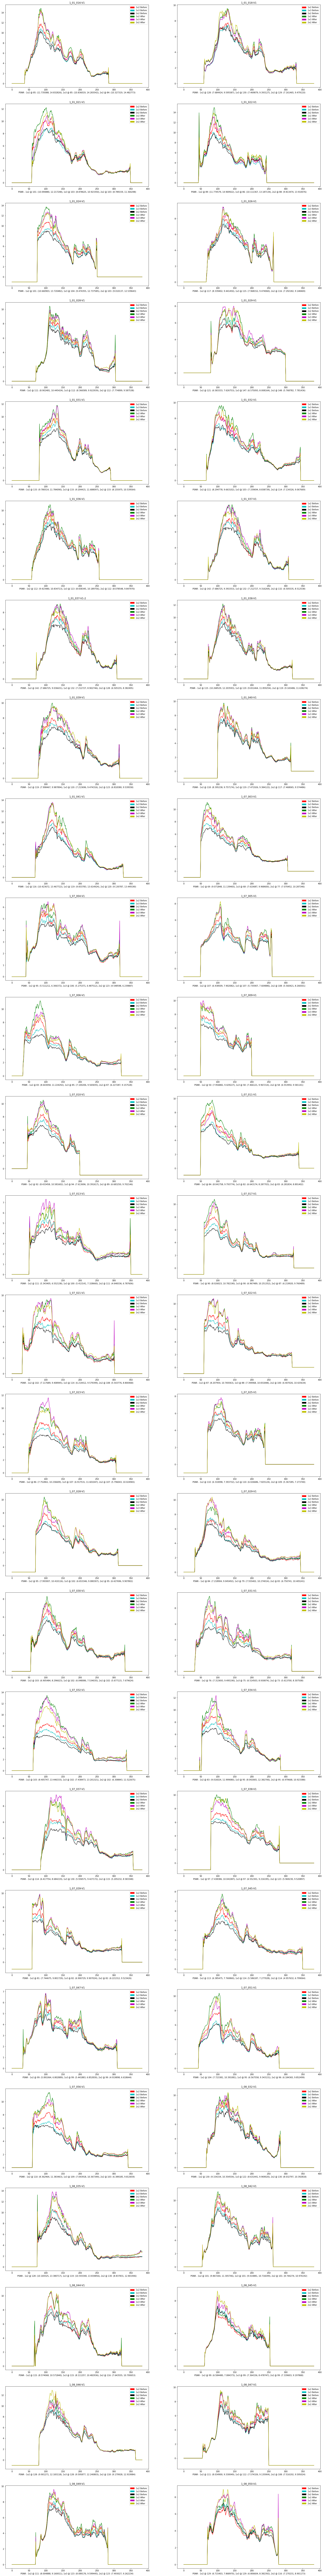

In [123]:
nrows, ncols = 26, 2

ACC_TO_SHOW = ['1x2', '1x3', '2x2']

figure, axis = plt.subplots(nrows, ncols, figsize=(28, nrows * 9))
after_max_idxs = []
isubj = 0
for irow in range(nrows):
    for icol in range(ncols):
        after_max_idx_1x2 = np.argmax(dataset[subj_ids[isubj]]['metrics']['1x2'][1]['axial_psnr'][1])
        after_max_idx_1x3 = np.argmax(dataset[subj_ids[isubj]]['metrics']['1x3'][1]['axial_psnr'][1])
        after_max_idx_2x2 = np.argmax(dataset[subj_ids[isubj]]['metrics']['2x2'][1]['axial_psnr'][1])
        
        before_max_1x2 = dataset[subj_ids[isubj]]['metrics']['1x2'][0]['axial_psnr'][1][after_max_idx_1x2]
        before_max_1x3 = dataset[subj_ids[isubj]]['metrics']['1x3'][0]['axial_psnr'][1][after_max_idx_1x3]
        before_max_2x2 = dataset[subj_ids[isubj]]['metrics']['2x2'][0]['axial_psnr'][1][after_max_idx_2x2]
        
        r_patch = mpatches.Patch(color='r', label='1x2 Before')
        c_patch = mpatches.Patch(color='c', label='1x3 Before')
        k_patch = mpatches.Patch(color='k', label='2x2 Before')
        g_patch = mpatches.Patch(color='g', label='1x2 After')
        m_patch = mpatches.Patch(color='m', label='1x3 After')
        y_patch = mpatches.Patch(color='y', label='2x2 After')
        
        axis[irow, icol].legend(handles=[r_patch, c_patch, k_patch, g_patch, m_patch, y_patch])

        axis[irow, icol].set_title('{}'.format(subj_ids[isubj]))
        
        if '1x2' in ACC_TO_SHOW:
            axis[irow, icol].plot(range(384), dataset[subj_ids[isubj]]['metrics']['1x2'][0]['axial_psnr'][1], 'r')
            axis[irow, icol].plot(range(384), dataset[subj_ids[isubj]]['metrics']['1x2'][1]['axial_psnr'][1], 'g')
        
        if '1x3' in ACC_TO_SHOW:
            axis[irow, icol].plot(range(384), dataset[subj_ids[isubj]]['metrics']['1x3'][0]['axial_psnr'][1], 'c')
            axis[irow, icol].plot(range(384), dataset[subj_ids[isubj]]['metrics']['1x3'][1]['axial_psnr'][1], 'm')
        
        if '2x2' in ACC_TO_SHOW:
            axis[irow, icol].plot(range(384), dataset[subj_ids[isubj]]['metrics']['2x2'][0]['axial_psnr'][1], 'k')
            axis[irow, icol].plot(range(384), dataset[subj_ids[isubj]]['metrics']['2x2'][1]['axial_psnr'][1], 'y')

        axis[irow, icol].set(xlabel='PSNR - 1x2 @ {}: ({:.6f}, {:.6f}), 1x3 @ {}: ({:.6f}, {:.6f}), 2x2 @ {}: ({:.6f}, {:.6f})'.format(
                after_max_idx_1x2, before_max_1x2, dataset[subj_ids[isubj]]['metrics']['1x2'][1]['axial_psnr'][0],
                after_max_idx_1x3, before_max_1x3, dataset[subj_ids[isubj]]['metrics']['1x3'][1]['axial_psnr'][0],
                after_max_idx_2x2, before_max_2x2, dataset[subj_ids[isubj]]['metrics']['2x2'][1]['axial_psnr'][0],
        ))

        # Comment out the ones you dont want
        #print(isubj, subj_ids[isubj], end=' ')
        #print(before_max_1x2, ', ', dataset[subj_ids[isubj]]['metrics']['1x2'][1]['axial_psnr'][0])
        #print(before_max_1x3, ', ', dataset[subj_ids[isubj]]['metrics']['1x3'][1]['axial_psnr'][0])
        #print(before_max_2x2, ', ', dataset[subj_ids[isubj]]['metrics']['2x2'][1]['axial_psnr'][0])
        
        isubj += 1

# Viz 3: SNR Improvement Plot

/tmp/ipykernel_952361/664553297.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=20)


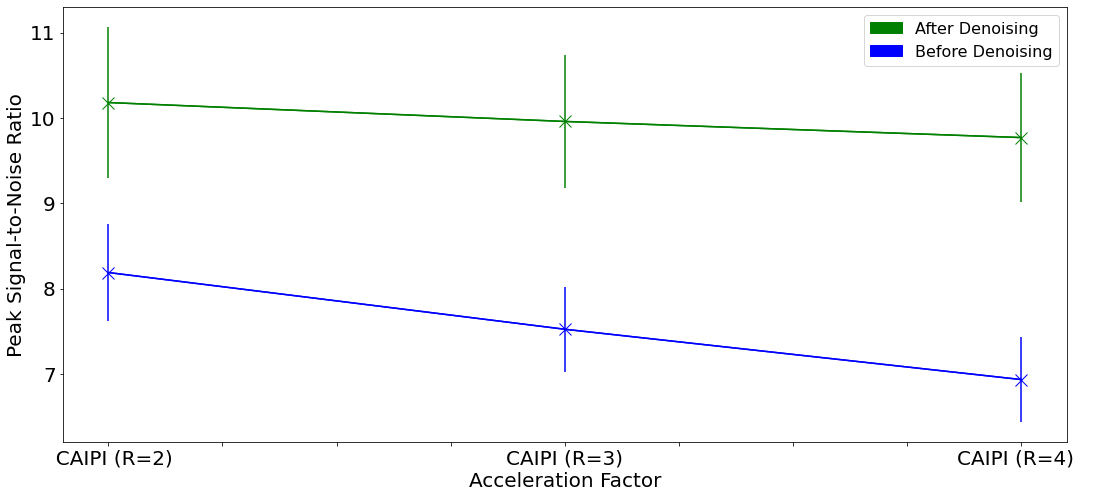

In [109]:
before_psnrs = [8.189097362, 7.52443476, 6.935097996]
after_psnrs  = [10.17999034, 9.958475584, 9.769799608]

before_std = [0.5668009573, 0.495909973, 0.4972347904]
after_std  = [0.8884878702, 0.78220119, 0.753520862]

pct_improvement = [24, 32, 41]

fig, ax = plt.subplots(figsize=(18,8))

xx = range(3)
ax.plot(xx, before_psnrs, marker='x', color='b', markersize=12)
ax.plot(xx, after_psnrs, marker='x', color='g', markersize=12)
for index in range(len(xx)):
    pass
    #ax.text(xx[index], after_psnrs[index],  '{} (+{}%)'.format(round(after_psnrs[index], 2), pct_improvement[index]) , size=11, ha='center', va='top')
    #ax.text(xx[index], before_psnrs[index], '{}'.format(round(before_psnrs[index], 2)) , size=11, va='bottom')

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [' ', '  CAIPI (R=2)', ' ', ' ', ' ', 'CAIPI (R=3)', ' ', ' ', ' ', 'CAIPI (R=4)  ']
ax.set_xticklabels(labels, fontsize=20)
ax.set_title('', fontsize=18)
plt.yticks(fontsize=20)

plt.errorbar(range(3), before_psnrs, yerr=before_std, color='b')
plt.errorbar(range(3), after_psnrs,  yerr=after_std, color='g')

b_patch = mpatches.Patch(color='b', label='Before Denoising')
g_patch = mpatches.Patch(color='g', label='After Denoising')
ax.legend(handles=[g_patch, b_patch], fontsize=16)

plt.xlabel('Acceleration Factor', fontsize=20)
plt.ylabel("Peak Signal-to-Noise Ratio", fontsize=20)

plt.show()

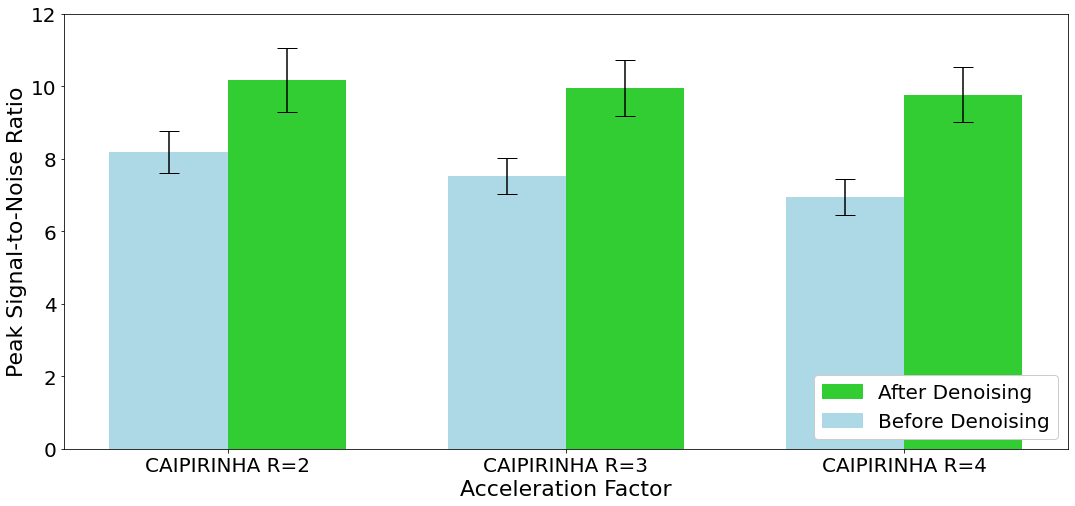

In [116]:
before_psnrs = [8.189097362, 7.52443476, 6.935097996]
after_psnrs  = [10.17999034, 9.958475584, 9.769799608]

before_std = [0.5668009573, 0.495909973, 0.4972347904]
after_std  = [0.8884878702, 0.78220119, 0.753520862]

pct_improvement = [24, 32, 41]

labels = ['CAIPIRINHA R=2', 'CAIPIRINHA R=3', 'CAIPIRINHA R=4']

fig, ax = plt.subplots(figsize=(18,8))

xx = np.arange(len(labels))

width = 0.35  # the width of the bars
rects1 = ax.bar(xx - width/2, before_psnrs, width, yerr=before_std, capsize=10, color='lightblue')
rects2 = ax.bar(xx + width/2, after_psnrs, width, yerr=after_std, capsize=10, color='limegreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(xx, labels)
ax.legend()

fig.canvas.draw()

ax.set_xticklabels(labels, fontsize=20)
ax.set_title('', fontsize=18)
plt.yticks(fontsize=20)

#plt.errorbar(xx - width/2, before_psnrs, yerr=before_std, color='b')
#plt.errorbar(xx + width/2, after_psnrs,  yerr=after_std, color='g')


b_patch = mpatches.Patch(color='lightblue', label='Before Denoising')
g_patch = mpatches.Patch(color='limegreen', label='After Denoising')

ax.legend(handles=[g_patch, b_patch], fontsize=20, loc='lower right', facecolor='white', framealpha=1)

plt.xlabel('Acceleration Factor', fontsize=22)
plt.ylabel("Peak Signal-to-Noise Ratio", fontsize=22)
plt.ylim([0,12])
plt.show()